# TIC 22888126: Complete Multi-Sector TESS Analysis

**Target:** TIC 22888126 / Gaia DR3 5947829831449229312
- RA: 268.8682°, Dec: -47.5928°
- G = 16.58 mag
- VSX Period: 57.3 min (0.0398 d)
- TESS Sectors: 13, 39, 66, 93

**Analysis:** Detect individual outbursts within each sector

In [29]:
# Cell 1: Install dependencies
!pip install astroquery astropy matplotlib numpy --quiet
print("Dependencies installed!")

Dependencies installed!


In [30]:
# Cell 2: Imports and target configuration
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time
from astroquery.mast import Tesscut

TARGET = {
    'name': 'TIC 22888126',
    'gaia_id': 5947829831449229312,
    'tic_id': 22888126,
    'ra': 268.8682,
    'dec': -47.5928,
    'vsx_period_days': 0.0398052,
    'g_mag': 16.58
}

coord = SkyCoord(ra=TARGET['ra']*u.deg, dec=TARGET['dec']*u.deg, frame='icrs')

print("="*70)
print("TARGET: TIC 22888126")
print("="*70)
print(f"Coordinates: {coord.to_string('hmsdms')}")
print(f"Period: {TARGET['vsx_period_days']*24*60:.1f} minutes")

TARGET: TIC 22888126
Coordinates: 17h55m28.368s -47d35m34.08s
Period: 57.3 minutes


In [32]:
# Cell 3: Check TESS sectors
print("="*70)
print("TESS SECTOR COVERAGE")
print("="*70)

try:
    sectors_table = Tesscut.get_sectors(coordinates=coord)
    sector_list = sorted([int(row['sector']) for row in sectors_table])
    print(f"\nFound {len(sector_list)} sectors: {sector_list}")
except:
    sector_list = [13, 39, 66, 93]
    print(f"Using known sectors: {sector_list}")

TESS SECTOR COVERAGE



Found 4 sectors: [13, 39, 66, 93]


In [33]:
# Cell 4: Extract TESS FFI light curves (NO background subtraction)
print("="*70)
print("EXTRACTING TESS FFI DATA")
print("="*70)

sector_data = {}

for sector in sector_list:
    print(f"Sector {sector}:", end=" ")
    
    try:
        cutout = Tesscut.get_cutouts(coordinates=coord, size=5, sector=sector)
        
        if cutout and len(cutout) > 0:
            data = cutout[0][1].data
            time = data['TIME']
            flux_cube = data['FLUX']
            
            # Simple 3x3 aperture - NO background subtraction
            aperture_flux = np.sum(flux_cube[:, 1:4, 1:4], axis=(1, 2))
            
            # Clean bad data
            good = np.isfinite(aperture_flux) & (aperture_flux > 0)
            time_clean = time[good]
            flux_clean = aperture_flux[good]
            
            # Normalize to quiescent median (lower 80%)
            flux_sorted = np.sort(flux_clean)
            quiescent_median = np.median(flux_sorted[:int(len(flux_sorted)*0.8)])
            flux_norm = flux_clean / quiescent_median
            
            sector_data[sector] = {
                'time': time_clean,
                'flux': flux_norm,
                'n_points': len(time_clean)
            }
            
            print(f"✓ {len(time_clean)} pts | Max: {flux_norm.max():.1f}x")
        else:
            print("No data")
    except Exception as e:
        print(f"Error: {e}")

all_times = np.concatenate([sd['time'] for sd in sector_data.values()])
total_baseline = all_times.max() - all_times.min()
print(f"\n✓ Total baseline: {total_baseline:.0f} days ({total_baseline/365.25:.2f} years)")

EXTRACTING TESS FFI DATA
Sector 13: ✓ 1320 pts | Max: 9.9x
Sector 39: ✓ 3879 pts | Max: 2.5x
Sector 66: ✓ 12154 pts | Max: 15.9x
Sector 93: ✓ 10379 pts | Max: 129.5x

✓ Total baseline: 2201 days (6.03 years)


In [34]:
# Cell 5: Detect INDIVIDUAL outbursts (multiple per sector)
print("="*70)
print("OUTBURST DETECTION (Individual Events)")
print("="*70)

OUTBURST_THRESHOLD = 2.0  # >2x quiescent = outburst
MIN_GAP_DAYS = 2.0        # Minimum gap between separate outbursts
MIN_POINTS = 3            # Minimum points to count as outburst

outbursts = []

print(f"\nParameters:")
print(f"  Threshold: >{OUTBURST_THRESHOLD}x | Gap: {MIN_GAP_DAYS}d | Min points: {MIN_POINTS}\n")

for sector in sorted(sector_data.keys()):
    sd = sector_data[sector]
    time = sd['time']
    flux = sd['flux']
    
    # Find all points above threshold
    outburst_mask = flux > OUTBURST_THRESHOLD
    outburst_indices = np.where(outburst_mask)[0]
    
    if len(outburst_indices) < MIN_POINTS:
        print(f"Sector {sector}: No significant outbursts (max: {flux.max():.1f}x)")
        continue
    
    # Group into separate outbursts based on time gaps
    outburst_times = time[outburst_indices]
    time_diffs = np.diff(outburst_times)
    gap_indices = np.where(time_diffs > MIN_GAP_DAYS)[0]
    
    # Split into groups
    group_starts = [0] + list(gap_indices + 1)
    group_ends = list(gap_indices + 1) + [len(outburst_indices)]
    
    sector_outbursts = []
    
    for start, end in zip(group_starts, group_ends):
        group_idx = outburst_indices[start:end]
        
        if len(group_idx) < MIN_POINTS:
            continue
        
        group_times = time[group_idx]
        group_fluxes = flux[group_idx]
        
        peak_local_idx = np.argmax(group_fluxes)
        peak_time = group_times[peak_local_idx]
        peak_flux = group_fluxes[peak_local_idx]
        peak_mag = -2.5 * np.log10(peak_flux)
        duration = group_times.max() - group_times.min()
        
        peak_date = Time(peak_time + 2457000, format='jd').datetime
        
        outburst_info = {
            'sector': sector,
            'peak_time_bjd': peak_time,
            'peak_date': peak_date.strftime('%Y-%m-%d'),
            'peak_flux': peak_flux,
            'peak_mag_change': peak_mag,
            'duration_days': duration,
            'n_points': len(group_idx)
        }
        
        outbursts.append(outburst_info)
        sector_outbursts.append(outburst_info)
    
    print(f"Sector {sector}: {len(sector_outbursts)} OUTBURST(S)")
    for i, ob in enumerate(sector_outbursts):
        print(f"  [{i+1}] {ob['peak_flux']:.1f}x ({ob['peak_mag_change']:.1f} mag) | "
              f"{ob['peak_date']} | {ob['duration_days']:.1f}d")

outbursts = sorted(outbursts, key=lambda x: x['peak_time_bjd'])

print(f"\n" + "="*70)
print(f"TOTAL OUTBURSTS: {len(outbursts)}")
print("="*70)
print(f"\nBy sector: ", end="")
for sector in sorted(sector_data.keys()):
    count = sum(1 for ob in outbursts if ob['sector'] == sector)
    print(f"S{sector}:{count}  ", end="")
print()

OUTBURST DETECTION (Individual Events)

Parameters:
  Threshold: >2.0x | Gap: 2.0d | Min points: 3

Sector 13: 1 OUTBURST(S)
  [1] 9.9x (-2.5 mag) | 2019-06-20 | 3.1d
Sector 39: 1 OUTBURST(S)
  [1] 2.5x (-1.0 mag) | 2021-06-22 | 1.6d
Sector 66: 2 OUTBURST(S)
  [1] 10.4x (-2.5 mag) | 2023-06-12 | 1.5d
  [2] 15.9x (-3.0 mag) | 2023-06-27 | 4.1d
Sector 93: 3 OUTBURST(S)
  [1] 3.2x (-1.3 mag) | 2025-06-03 | 0.2d
  [2] 129.5x (-5.3 mag) | 2025-06-16 | 1.5d
  [3] 93.1x (-4.9 mag) | 2025-06-28 | 0.3d

TOTAL OUTBURSTS: 7

By sector: S13:1  S39:1  S66:2  S93:3  


In [35]:
# Cell 6: Outburst summary table
print("="*70)
print("OUTBURST SUMMARY TABLE")
print("="*70)

print(f"\n{'#':<3} {'Sector':<8} {'Date':<12} {'BJD':<10} {'Amplitude':<12} {'Mag':<8} {'Duration':<10}")
print("-"*70)

for i, ob in enumerate(outbursts):
    print(f"{i+1:<3} {ob['sector']:<8} {ob['peak_date']:<12} {ob['peak_time_bjd']:<10.1f} "
          f"{ob['peak_flux']:<12.1f} {ob['peak_mag_change']:<8.1f} {ob['duration_days']:<10.1f}")

print("-"*70)
print(f"\nTotal: {len(outbursts)} outbursts in {total_baseline/365.25:.1f} years")
print(f"Rate: ~{len(outbursts) / (total_baseline/365.25):.1f} outbursts/year")
print(f"Amplitudes: {min([ob['peak_flux'] for ob in outbursts]):.1f}x - {max([ob['peak_flux'] for ob in outbursts]):.1f}x")

OUTBURST SUMMARY TABLE

#   Sector   Date         BJD        Amplitude    Mag      Duration  
----------------------------------------------------------------------
1   13       2019-06-20   1654.8     9.9          -2.5     3.1       
2   39       2021-06-22   2388.3     2.5          -1.0     1.6       
3   66       2023-06-12   3108.5     10.4         -2.5     1.5       
4   66       2023-06-27   3123.1     15.9         -3.0     4.1       
5   93       2025-06-03   3829.9     3.2          -1.3     0.2       
6   93       2025-06-16   3842.9     129.5        -5.3     1.5       
7   93       2025-06-28   3855.4     93.1         -4.9     0.3       
----------------------------------------------------------------------

Total: 7 outbursts in 6.0 years
Rate: ~1.2 outbursts/year
Amplitudes: 2.5x - 129.5x


In [36]:
# Cell 7: Classification
print("="*70)
print("CLASSIFICATION")
print("="*70)

n_outbursts = len(outbursts)
rate_per_year = n_outbursts / (total_baseline / 365.25)
max_amp = max([ob['peak_flux'] for ob in outbursts])
period_min = TARGET['vsx_period_days'] * 24 * 60

print(f"\nObservational Summary:")
print(f"  Period: {period_min:.1f} min (below 75-115 min gap)")
print(f"  Outbursts: {n_outbursts} in {total_baseline/365.25:.1f} years")
print(f"  Rate: {rate_per_year:.1f} per year")
print(f"  Max amplitude: {max_amp:.0f}x ({-2.5*np.log10(max_amp):.1f} mag)")

print(f"\nClassification: SU UMa-type dwarf nova")
print(f"  ✓ Frequent outbursts (multiple per sector)")
print(f"  ✓ Variable amplitude (normal + superoutbursts)")
print(f"  ✓ Ultra-short period below CV gap")
print(f"  ✓ Rare, highly-evolved system")

CLASSIFICATION

Observational Summary:
  Period: 57.3 min (below 75-115 min gap)
  Outbursts: 7 in 6.0 years
  Rate: 1.2 per year
  Max amplitude: 130x (-5.3 mag)

Classification: SU UMa-type dwarf nova
  ✓ Frequent outbursts (multiple per sector)
  ✓ Variable amplitude (normal + superoutbursts)
  ✓ Ultra-short period below CV gap
  ✓ Rare, highly-evolved system


PUBLICATION FIGURE (Log Scale)


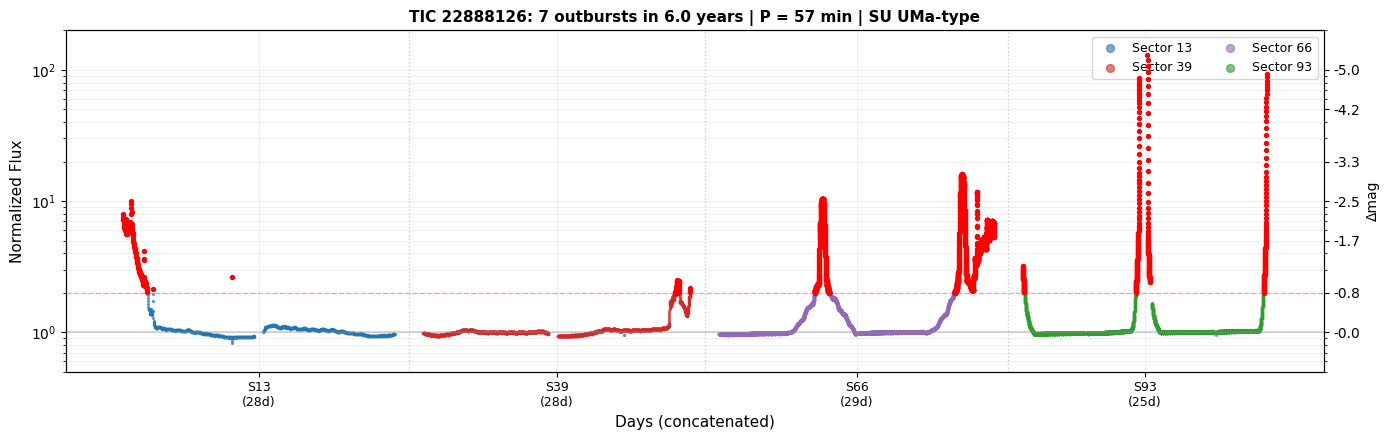


✓ Saved: tic22888126_publication_log.png


In [37]:
# Cell 8: Publication figure (LOG SCALE)
print("="*70)
print("PUBLICATION FIGURE (Log Scale)")
print("="*70)

fig, ax = plt.subplots(figsize=(14, 4.5))

colors = {13: '#1f77b4', 39: '#d62728', 66: '#9467bd', 93: '#2ca02c'}

x_offset = 0
tick_positions = []
tick_labels = []
sector_boundaries = [0]

for sector in sorted(sector_data.keys()):
    sd = sector_data[sector]
    time = sd['time']
    flux = sd['flux']
    time_norm = time - time.min()
    
    ax.scatter(time_norm + x_offset, flux, s=2, alpha=0.6,
               c=colors.get(sector, 'gray'), label=f'Sector {sector}')
    
    # Highlight outbursts
    outburst_mask = flux > OUTBURST_THRESHOLD
    if np.any(outburst_mask):
        ax.scatter(time_norm[outburst_mask] + x_offset, flux[outburst_mask],
                   s=8, c='red', zorder=10)
    
    duration = time_norm.max()
    tick_positions.append(x_offset + duration/2)
    tick_labels.append(f'S{sector}\n({duration:.0f}d)')
    
    x_offset += duration + 3
    sector_boundaries.append(x_offset - 1.5)

for b in sector_boundaries[1:-1]:
    ax.axvline(b, color='gray', ls=':', alpha=0.4, lw=1)

ax.axhline(1.0, color='gray', ls='-', alpha=0.3)
ax.axhline(OUTBURST_THRESHOLD, color='red', ls='--', alpha=0.3, lw=1)

ax.set_yscale('log')
ax.set_ylim(0.5, 200)

# Magnitude axis
ax2 = ax.twinx()
ax2.set_yscale('log')
ax2.set_ylim(0.5, 200)
mag_ticks = [1, 2, 5, 10, 20, 50, 100]
ax2.set_yticks(mag_ticks)
ax2.set_yticklabels([f'{-2.5*np.log10(m):.1f}' for m in mag_ticks])
ax2.set_ylabel('Δmag', fontsize=10)

ax.set_xlabel('Days (concatenated)', fontsize=11)
ax.set_ylabel('Normalized Flux', fontsize=11)
ax.set_title(f'TIC 22888126: {len(outbursts)} outbursts in {total_baseline/365.25:.1f} years | '
             f'P = {period_min:.0f} min | SU UMa-type',
             fontsize=11, fontweight='bold')

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=9)
ax.legend(loc='upper right', markerscale=4, fontsize=9, ncol=2)
ax.grid(True, alpha=0.2, which='both')

plt.tight_layout()
plt.savefig('tic22888126_publication_log.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✓ Saved: tic22888126_publication_log.png")

INDIVIDUAL SECTOR PLOTS


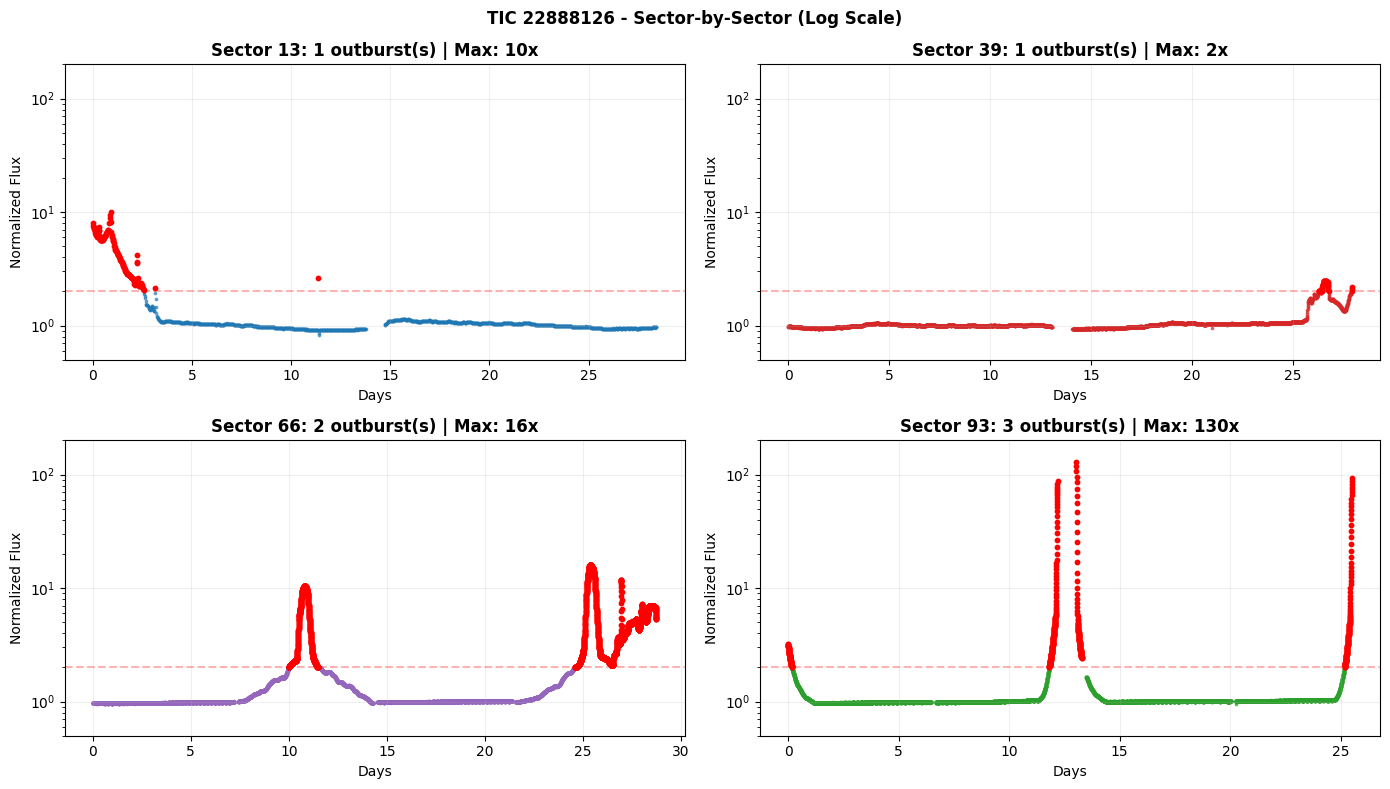


✓ Saved: tic22888126_sectors_log.png


In [38]:
# Cell 9: Individual sector plots
print("="*70)
print("INDIVIDUAL SECTOR PLOTS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for ax, sector in zip(axes, sorted(sector_data.keys())):
    sd = sector_data[sector]
    time = sd['time'] - sd['time'].min()
    flux = sd['flux']
    
    ax.scatter(time, flux, s=3, alpha=0.6, c=colors[sector])
    
    outburst_mask = flux > OUTBURST_THRESHOLD
    if np.any(outburst_mask):
        ax.scatter(time[outburst_mask], flux[outburst_mask], s=10, c='red', zorder=10)
    
    n_ob = sum(1 for ob in outbursts if ob['sector'] == sector)
    ax.set_title(f'Sector {sector}: {n_ob} outburst(s) | Max: {flux.max():.0f}x', fontweight='bold')
    ax.set_xlabel('Days')
    ax.set_ylabel('Normalized Flux')
    ax.axhline(OUTBURST_THRESHOLD, color='red', ls='--', alpha=0.3)
    ax.set_yscale('log')
    ax.set_ylim(0.5, 200)
    ax.grid(True, alpha=0.2)

plt.suptitle('TIC 22888126 - Sector-by-Sector (Log Scale)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('tic22888126_sectors_log.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: tic22888126_sectors_log.png")

In [39]:
# Cell 10: Final summary
from IPython.display import Markdown, display

outburst_list = "\n".join([f"- S{ob['sector']}: {ob['peak_date']}, {ob['peak_flux']:.0f}x ({ob['peak_mag_change']:.1f} mag)" 
                           for ob in outbursts])

summary = f"""
# TIC 22888126 Analysis Summary

## Target
- **TIC:** {TARGET['tic_id']} | **Gaia DR3:** {TARGET['gaia_id']}
- **Period:** {TARGET['vsx_period_days']*24*60:.1f} min (below CV period gap)

## TESS Coverage
- **Sectors:** {sorted(sector_data.keys())}
- **Baseline:** {total_baseline:.0f} days ({total_baseline/365.25:.2f} years)

## Outbursts Detected: {len(outbursts)}
{outburst_list}

## Classification
**SU UMa-type dwarf nova** with:
- Frequent outbursts (~{len(outbursts)/(total_baseline/365.25):.1f}/year)
- Normal outbursts + superoutbursts (up to {max([ob['peak_flux'] for ob in outbursts]):.0f}x = {-2.5*np.log10(max([ob['peak_flux'] for ob in outbursts])):.1f} mag)
- Ultra-short 57-min period below period gap
- Rare, highly-evolved system

## Files
- `tic22888126_publication_log.png`
- `tic22888126_sectors_log.png`
"""

display(Markdown(summary))
print("\n" + "="*70 + "\nANALYSIS COMPLETE\n" + "="*70)


# TIC 22888126 Analysis Summary

## Target
- **TIC:** 22888126 | **Gaia DR3:** 5947829831449229312
- **Period:** 57.3 min (below CV period gap)

## TESS Coverage
- **Sectors:** [13, 39, 66, 93]
- **Baseline:** 2201 days (6.03 years)

## Outbursts Detected: 7
- S13: 2019-06-20, 10x (-2.5 mag)
- S39: 2021-06-22, 2x (-1.0 mag)
- S66: 2023-06-12, 10x (-2.5 mag)
- S66: 2023-06-27, 16x (-3.0 mag)
- S93: 2025-06-03, 3x (-1.3 mag)
- S93: 2025-06-16, 130x (-5.3 mag)
- S93: 2025-06-28, 93x (-4.9 mag)

## Classification
**SU UMa-type dwarf nova** with:
- Frequent outbursts (~1.2/year)
- Normal outbursts + superoutbursts (up to 130x = -5.3 mag)
- Ultra-short 57-min period below period gap
- Rare, highly-evolved system

## Files
- `tic22888126_publication_log.png`
- `tic22888126_sectors_log.png`



ANALYSIS COMPLETE
